In [1]:
# 경고 무시

import warnings

warnings.filterwarnings(action='ignore')

In [2]:
# 주요 라이브러리 임포트 
import torch

from torch import nn 
from torch.autograd import Variable

from torchvision import datasets, transforms
from torch.utils import data

import torch.nn.functional as F

import numpy as np

import matplotlib.pyplot as plt

import math

In [3]:
# 연산 장치 지정

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device

device(type='cuda', index=0)

In [4]:
# CIFAR-10 데이터 로드 전 평균과 표준편차 구함

# 데이터 연산을 위한 Tensor 변환
transform_data = transforms.Compose([transforms.ToTensor()])

# 평균&표준편차 연산을 위해 모델 데이터 로드
train_data = datasets.CIFAR10('data/CIFAR-10/', download=True, train= True, transform=transform_data)
validate_data = datasets.CIFAR10('data/CIFAR-10/', download=True, train= False, transform=transform_data)

# 평균&표준편차 계산
def get_mean_std(dataset) :
    meanRGB = [np.mean(image.numpy(), axis=(1,2)) for image,_ in dataset] # 이미지 마다 각 채널의 R,G,B 평균
    stdRGB = [np.std(image.numpy(), axis=(1,2)) for image,_ in dataset] # 이미지 마다 각 채널의 R,G,B 표준편차

    meanR = np.mean([mean[0] for mean in meanRGB])  #각 채널 R값의 평균
    meanG = np.mean([mean[1] for mean in meanRGB])  #각 채널 G값의 평균
    meanB = np.mean([mean[2] for mean in meanRGB])  #각 채널 G값의 평균

    stdR = np.mean([std[0] for std in stdRGB])  #각 채널 R값의 표준편차
    stdG = np.mean([std[1] for std in stdRGB])  #각 채널 G값의 표준편차
    stdB = np.mean([std[2] for std in stdRGB])  #각 채널 B값의 표준편차

    return (meanR, meanG, meanB),(stdR,stdG,stdB) #각 값을 튜플로 리턴

train_means, train_stds = get_mean_std(train_data)
validate_means, validate_stds = get_mean_std(validate_data)

print(train_means, train_stds)
print(validate_means, validate_stds)

Files already downloaded and verified
Files already downloaded and verified
(0.49139965, 0.48215845, 0.4465309) (0.20220213, 0.19931543, 0.20086348)
(0.49421427, 0.48513138, 0.45040908) (0.20189482, 0.19902097, 0.20103233)


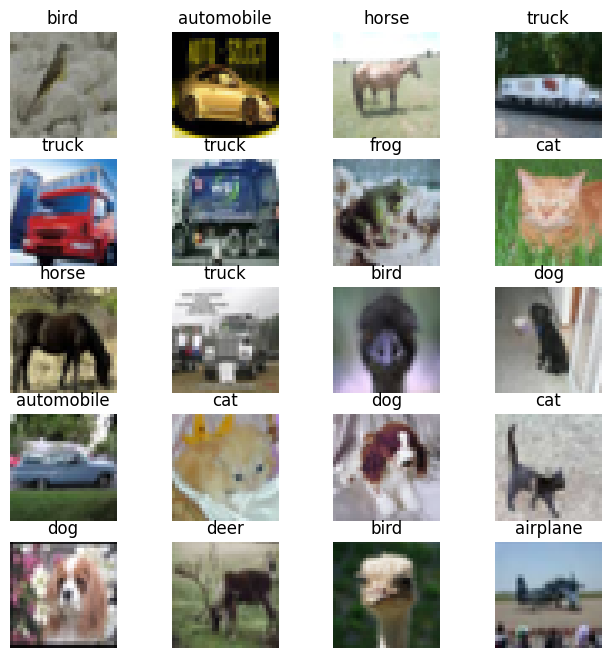

In [5]:
# 평균화 하기 전 이미지
labels_map = {0 : 'airplane', 1 : 'automobile', 2 : 'bird', 3 : 'cat', 4 : 'deer', 5 : 'dog', 6 : 'frog', 7 : 'horse', 8 : 'ship', 9 : 'truck'}

fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 5;
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_data));
    img = transforms.ToPILImage()(train_data[img_xy][0])
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_data[img_xy][1]])
    plt.axis('off')
    plt.imshow(img)

plt.show()

In [6]:
# 이미지 평균화
transform_train = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(train_means,train_stds) # 이전 계산 한 평균, 표준편차 값 이용
    ])
transform_validate = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(validate_means, validate_stds) # 이전 계산 한 평균, 표준편차 값 이용
])

train_data = datasets.CIFAR10('data/CIFAR-10/', download=True, train= True, transform=transform_train) # 훈련 데이터 50,000
validate_data = datasets.CIFAR10('data/CIFAR-10/', download=True, train= False, transform=transform_validate) # 검증 데이터 10,000

train_loader = data.DataLoader(train_data, batch_size=100) # 데이터르 100개 씩 나눠서 이용
validate_loader = data.DataLoader(validate_data, batch_size=100) 

Files already downloaded and verified
Files already downloaded and verified


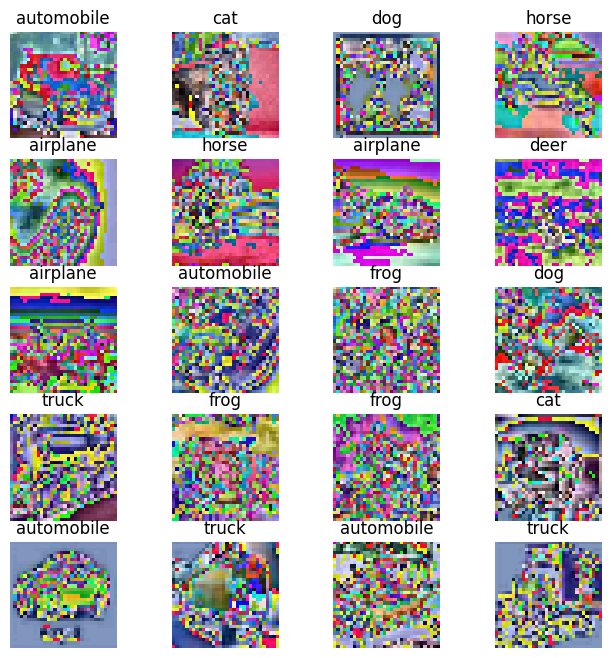

In [50]:
# 평균화 된 이미지 확인

labels_map = {0 : 'airplane', 1 : 'automobile', 2 : 'bird', 3 : 'cat', 4 : 'deer', 5 : 'dog', 6 : 'frog',
              7 : 'horse', 8 : 'ship', 9 : 'truck'}

fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 5;
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_data));
    img = transforms.ToPILImage()(train_data[img_xy][0])
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_data[img_xy][1]])
    plt.axis('off')
    plt.imshow(img)

plt.show()

In [8]:
# 5주차의 CNN 기본 예제의 망을 활용한 모델

class CifarCNN1(nn.Module):    
    def __init__(self):
        super(CifarCNN1, self).__init__()        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )       
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2) # 64,7,7
        )        
        self.fc1 = nn.Linear(in_features=64*7*7, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)     
        return out

learning_rate1 = 0.001;
model1 = CifarCNN1();
model1.to(device)

criterion1 = nn.CrossEntropyLoss();
optimizer1 = torch.optim.Adam(model1.parameters(), lr=learning_rate1);
print(model1)

CifarCNN1(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=3136, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [18]:
# 컨볼루션 레이어를 하나 더 추가 한뒤 완전 연결 레이어의 크기를 조절한 모델

class CifarCNN2(nn.Module):    
    def __init__(self):
        super(CifarCNN2, self).__init__()        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )       
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )   
        self.layer3 = nn.Sequential(  # 컨볼루션 레이어 추가
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 256,2,2
        )        
        self.fc1 = nn.Linear(in_features=256*2*2, out_features=1024)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=1024, out_features=512)
        self.fc3 = nn.Linear(in_features=512, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(-1, 256*2*2)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)     
        return out
    
learning_rate2 = 0.001;
model2 = CifarCNN2();
model2.to(device)

criterion2 = nn.CrossEntropyLoss();
optimizer2 = torch.optim.Adam(model2.parameters(), lr=learning_rate2);
print(model2)

CifarCNN2(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=1024, 

In [10]:
class CifarLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(CifarLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.x2h = nn.Linear(input_size, 4*hidden_size, bias=bias)
        self.h2h= nn.Linear(hidden_size, 4 * hidden_size, bias= bias)
        self.reset_parameters()
    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)
    def forward(self, x, hidden):
        hx, cx = hidden
        x = x.view(-1, x.size(1))

        gates = self.x2h(x) + self.h2h(hx)
        gates = gates.squeeze()
        ingate, forgetgate, cellgate, outgate = gates.chunk(4,1)

        ingate = F.sigmoid(ingate)
        forgetgate = F.sigmoid(forgetgate)
        cellgate = F.tanh(cellgate)
        outgate = F.sigmoid(outgate)

        cy = torch.mul(cx, forgetgate) + torch.mul(ingate, cellgate)
        hy = torch.mul(outgate, F.tanh(cy))
        return (hy,cy)

class CifarLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias=True):
        super(CifarLSTM, self).__init__()
        self.hidden_dim = hidden_dim

        self.layer_dim = layer_dim
        self.lstm = CifarLSTMCell(input_dim, hidden_dim, layer_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        if torch.cuda.is_available():
            h0 = Variable(torch.zeros(self.layer_dim, x.size(0),self.hidden_dim).cuda())
        else:
            h0 = Variable(torch.zeros(self.layer_dim, x.size(0),self.hidden_dim))

        if torch.cuda.is_available():
            c0 = Variable(torch.zeros(self.layer_dim, x.size(0),self.hidden_dim).cuda())
        else: 
            c0 = Variable(torch.zeros(self.layer_dim, x.size(0),self.hidden_dim))
        
        outs = []
        cn = c0[0,:,:]
        hn = h0[0,:,:]

        for seq in range(x.size(1)):
            hn, cn = self.lstm(x[:,seq,:], (hn,cn))
            outs.append(hn)
        
        out = outs[-1].squeeze()
        out = self.fc(out)
        return out

input_dim = 32*3 # 채널이 3개인 행이 32 픽셀인 이미지 
hidden_dim = 128
layer_dim = 1
output_dim = 10 # 출력이 10개

model3 = CifarLSTM(input_dim, hidden_dim, layer_dim, output_dim)
if torch.cuda.is_available():
    model3.cuda()

criterion3 = nn.CrossEntropyLoss()
learning_rate3 = 0.1
optimizer3 = torch.optim.SGD(model3.parameters(), lr=learning_rate3)

print(model3)

CifarLSTM(
  (lstm): CifarLSTMCell(
    (x2h): Linear(in_features=96, out_features=512, bias=True)
    (h2h): Linear(in_features=128, out_features=512, bias=True)
  )
  (fc): Linear(in_features=128, out_features=10, bias=True)
)


In [11]:
num_epochs = 5
count = 0

loss_list1 = []
iteration_list1 = []
accuracy_list1 = []

predictions_list1 = []
labels_list1 = []

print("CifarCNN1")

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(100, 3, 32, 32))
        labels = Variable(labels)
        
        outputs = model1(train)
        loss = criterion1(outputs, labels)
        optimizer1.zero_grad()
        loss.backward()
        optimizer1.step()
        count += 1
    
        if not (count % 50):    
            total = 0
            correct = 0        
            for images, labels in validate_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list1.append(labels)            
                test = Variable(images.view(100, 3, 32, 32))            
                outputs = model1(test)            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list1.append(predictions)
                correct += (predictions == labels).sum()            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list1.append(loss.data)
            iteration_list1.append(count)
            accuracy_list1.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

CifarCNN1
Iteration: 500, Loss: 1.182397484779358, Accuracy: 59.619998931884766%
Iteration: 1000, Loss: 0.9864479899406433, Accuracy: 65.12999725341797%
Iteration: 1500, Loss: 0.892157793045044, Accuracy: 67.0%
Iteration: 2000, Loss: 0.8299127221107483, Accuracy: 68.65999603271484%
Iteration: 2500, Loss: 0.7070215344429016, Accuracy: 70.19999694824219%


In [19]:
num_epochs = 5
count = 0

loss_list2 = []
iteration_list2 = []
accuracy_list2 = []

predictions_list2 = []
labels_list2 = []

print("CifarCNN2")

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(100, 3, 32, 32))
        labels = Variable(labels)
        
        outputs = model2(train)
        loss = criterion2(outputs, labels)
        optimizer2.zero_grad()
        loss.backward()
        optimizer2.step()
        count += 1
    
        if not (count % 50):    
            total = 0
            correct = 0        
            for images, labels in validate_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list2.append(labels)            
                test = Variable(images.view(100, 3, 32, 32))            
                outputs = model2(test)            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list2.append(predictions)
                correct += (predictions == labels).sum()            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list2.append(loss.data)
            iteration_list2.append(count)
            accuracy_list2.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

CifarCNN2
Iteration: 500, Loss: 1.0582914352416992, Accuracy: 63.53999710083008%
Iteration: 1000, Loss: 0.9011398553848267, Accuracy: 68.87999725341797%
Iteration: 1500, Loss: 0.6624347567558289, Accuracy: 71.66999816894531%
Iteration: 2000, Loss: 0.530362606048584, Accuracy: 72.50999450683594%
Iteration: 2500, Loss: 0.47905319929122925, Accuracy: 72.61000061035156%


In [13]:
num_epochs =  5

seq_dim = 32


loss_list3 = []
iteration_list3 = []
accuracy_list3 = []

count = 0

print("CifarLSTM")

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images = Variable(images.view(-1, seq_dim, input_dim).cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images.view(-1, seq_dim, input_dim))
            labels = Variable(labels)
        
        optimizer3.zero_grad()
        outputs = model3(images)

        loss = criterion3(outputs, labels)

        if torch.cuda.is_available():
            loss.cuda()
        
        loss.backward()
        optimizer3.step()
        count += 1

        if not (count % 50):
            correct = 0
            total = 0
            for images, labels in validate_loader:
                if torch.cuda.is_available():
                    images = Variable(images.view(-1, seq_dim, input_dim).cuda())
                else:
                    images = Variable(images.view(-1, seq_dim, input_dim))

                outputs = model3(images)
                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()
                
            accuracy = 100 * correct / total

            loss_list3.append(loss.data)
            iteration_list3.append(count)
            accuracy_list3.append(accuracy)

        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.item(), accuracy))

CifarLSTM
Iteration: 500, Loss: 2.0395967960357666, Accuracy: 29.739999771118164%
Iteration: 1000, Loss: 1.882307767868042, Accuracy: 34.66999816894531%
Iteration: 1500, Loss: 1.7115261554718018, Accuracy: 38.06999969482422%
Iteration: 2000, Loss: 1.6299848556518555, Accuracy: 40.91999816894531%
Iteration: 2500, Loss: 1.5851932764053345, Accuracy: 42.619998931884766%


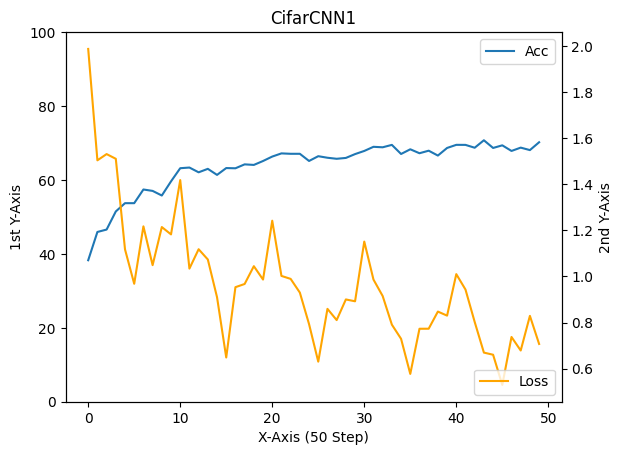

In [48]:
accuracy_list = [acc.cpu() for acc in accuracy_list1]
loss_list = [loss.cpu() for loss in loss_list1]

plt.style.use('default')

fig, ax1 = plt.subplots()
ax1.set_xlabel('X-Axis (50 Step)')
ax1.set_ylabel('1st Y-Axis')
ax1.set_ylim(0,100)

ax1.plot(accuracy_list, label='Acc')
ax1.legend(loc='upper right')

ax2 = ax1.twinx()
ax2.set_ylabel('2nd Y-Axis')
ax2.plot(loss_list, color='orange', label='Loss')
ax2.legend(loc='lower right')


plt.title("CifarCNN1")
plt.show()

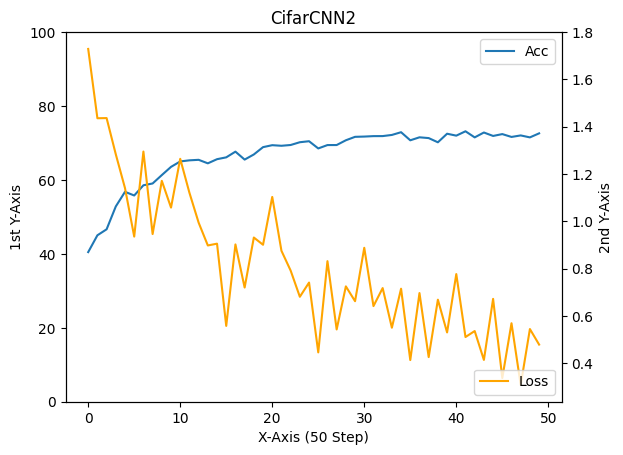

In [44]:
accuracy_list = [acc.cpu() for acc in accuracy_list2]
loss_list = [loss.cpu() for loss in loss_list2]

plt.style.use('default')

fig, ax1 = plt.subplots()
ax1.set_xlabel('X-Axis (50 Step)')
ax1.set_ylabel('1st Y-Axis')
ax1.set_ylim(0,100)

ax1.plot(accuracy_list, label='Acc')
ax1.legend(loc='upper right')

ax2 = ax1.twinx()
ax2.set_ylabel('2nd Y-Axis')
ax2.plot(loss_list, color='orange', label='Loss')
ax2.legend(loc='lower right')

plt.title("CifarCNN2")
plt.show()

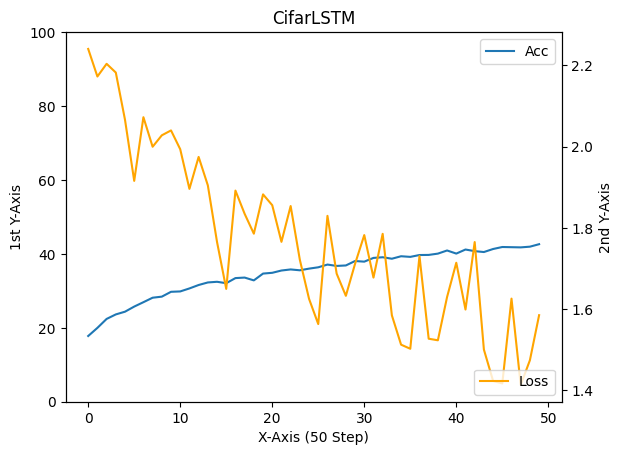

In [49]:
accuracy_list = [acc.cpu() for acc in accuracy_list3]
loss_list = [loss.cpu() for loss in loss_list3]

plt.style.use('default')

fig, ax1 = plt.subplots()
ax1.set_xlabel('X-Axis (50 Step)')
ax1.set_ylabel('1st Y-Axis')
ax1.set_ylim(0,100)

ax1.plot(accuracy_list, label='Acc')
ax1.legend(loc='upper right')

ax2 = ax1.twinx()
ax2.set_ylabel('2nd Y-Axis')
ax2.plot(loss_list, color='orange', label='Loss')
ax2.legend(loc='lower right')

plt.title("CifarLSTM")
plt.show()